In [1]:
import torch
import tsensor
W = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([9, 10]).reshape(2, 1)
x = torch.tensor([4, 5]).reshape(2, 1)
z = torch.tensor([1,2,3])
# z + z + W @ z
# W @ z
#torch.dot(b, 3)
# with tsensor.dbg():
#     W @ torch.dot(b,b)+ torch.eye(2,2)@x + z
# W[33, 33] = 3
b = torch.abs( W @ b + x )

## Graphviz

In [34]:
p = tsensor.PyExprParser("b = W @ h + self.f(x)*2")
print(p.tokens)
root = p.parse()
root

[<NAME:b>, <EQUAL:=>, <NAME:W>, <AT:@>, <NAME:h>, <PLUS:+>, <NAME:self>, <DOT:.>, <NAME:f>, <LPAR:(>, <NAME:x>, <RPAR:)>, <STAR:*>, <NUMBER:2>, <ENDMARKER:>]


Assign(lhs=b,rhs=BinaryOp(op=<PLUS:+>,lhs=BinaryOp(op=<AT:@>,lhs=W,rhs=h),rhs=BinaryOp(op=<STAR:*>,lhs=Call(func=Member(obj=self,member=f),args=[x]),rhs=2)))

In [35]:
def postorder(t):
    nodes = []
    _postorder(t, nodes)
    return nodes
def _postorder(t, nodes):
    if t is None:
        return
    for sub in t.kids:
        _postorder(sub, nodes)
    nodes.append(t)

In [36]:
def leaves(t):
    nodes = []
    _leaves(t, nodes)
    return nodes
def _leaves(t, nodes):
    if t is None:
        return
    if len(t.kids)==0:
        nodes.append(t)
        return
    for sub in t.kids:
        _leaves(sub, nodes)

In [37]:
nodes = postorder(root)
atoms = leaves(root)
atoms

[b, W, h, self, f, x, 2]

In [49]:
# map tokens to nodes
tok2node = {}
for nd in atoms:
    tok2node[nd.token] = nd

In [38]:
def walk(t, pre=lambda x:None, post=lambda x:None):
    if t is None:
        return
    pre(t)
    for sub in t.kids:
        walk(sub, pre, post)
    post(t)

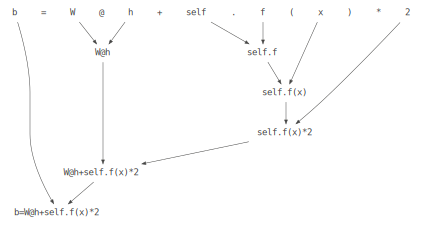

In [76]:
import graphviz

s = """
digraph G {
    nodesep=.1;
    ranksep=.3;
    rankdir=BT;
    ordering=out; # keep order of leaves
    node [penwidth="0.5", shape=plaintext, width=.1, height=.1];
"""

nodesS = set(nodes)
atomsS = set(atoms)
ops = nodesS.difference(atomsS)

# s += f'{{ rank=same;'
# for a in atoms:
#     s += f' node{id(tok2node[a.token])};'
# s += '}\n'

s += f'{{ rank=same;'
for t in p.tokens:
    if t.type!=tsensor.ENDMARKER:
        x = tok2node[t] if t in tok2node else t
        s += f'leaf{id(x)} [label=<<font face="Consolas" color="#444443" point-size="9">{t.value}</font>>]'
s += '}\n'

# for nd in ops:
#     s += f'leaf{id(nd)} [label=<<font face="Consolas" color="#444443" point-size="9">{str(nd)}</font>>]'

for nd in nodes:
    if nd in ops:
        s += f'node{id(nd)} [label=<<font face="Consolas" color="#444443" point-size="9">{str(nd)}</font>>]'

# link leaves left to right
for i in range(len(p.tokens)-2):
    t = p.tokens[i]
    t2 = p.tokens[i+1]
    x = tok2node[t] if t in tok2node else t
    x2 = tok2node[t2] if t2 in tok2node else t2
    s += f'leaf{id(x)} -> leaf{id(x2)} [style=invis];'
    
for nd in nodes:
    for sub in nd.kids:
        if sub in atomsS:
            s += f'node{id(nd)} -> leaf{id(sub)} [dir=back, penwidth="0.5", color="#444443", arrowsize=.4];'
        else:
            s += f'node{id(nd)} -> node{id(sub)} [dir=back, penwidth="0.5", color="#444443", arrowsize=.4];'
s += "}\n"
graphviz.Source(s)

## CSS (yuck)

In [ ]:
from IPython.core.display import display, HTML
h = """
<h6 style="color: Green; position:absolute; top: 20vh; left: 25vw; height: auto; margin: auto;">Actief</h6>
<table>
<tr>
    <td>b = torch.abs( W @ b +</td>
    <td><div style="width:100px;height:150px;border:1px solid #000;">
    <table style="width:100px;height:150px" border='0' cellborder='0' cellpadding="0" cellspacing="0">
           <tr>
               <td height="50%" width="33%"></td>
               <td width="33%" cellpadding="0" cellspacing="0" align=center valign=top>40</td><td width="33%"></td>
           </tr>
           <tr>
               <td width="33%" cellpadding="0" cellspacing="0">100</td>
               <td width="33%" cellpadding="0" cellspacing="0" align="center">self.W</td>
               <td width="33%"></td>
           </tr>
         </table>
    </div>
    </td>
    <td>)</td>
</tr>
"""
t = HTML(h)
t

In [ ]:
def matrix(nrows,ncols,text,dim_fontsize=9,fontsize=12):
    h = f"""
    <div style="position:relative; width:{ncols}px;height:{nrows*1.2}px; padding:0px">
     <div style="position:relative; width:{ncols}px;height:{nrows}px;border:1px solid #000; padding:0px">
      <div style="position:absolute; width:{ncols}px; top: -3px; text-align:center; font-size:{dim_fontsize}px">
        {ncols}
      </div>
      <div style="position:absolute; top: 40%; left: -3px; transform: rotate(-90deg); font-size:{dim_fontsize}px">
        {nrows}
      </div>
     </div>
     <div style="position:absolute; width:{ncols}px; bottom: 5px; text-align:center; font-size:{fontsize}px">
        {text}
     </div>
    </div>
    """
    sp = f"""
    <div style="position:relative; width:{ncols}px;height:{nrows*1.2}px; padding:0px">
     <span style="position:relative; width:{ncols}px;height:{nrows}px;border:1px solid #000; padding:0px">
      <span style="position:absolute; width:{ncols}px; top: -3px; text-align:center; font-size:{dim_fontsize}px">
        {ncols}
      </span>
      <span style="position:absolute; top: 40%; left: -3px; transform: rotate(-90deg); font-size:{dim_fontsize}px">
        {nrows}
      </span>
     </span>
     <span style="position:absolute; width:{ncols}px; bottom: 5px; text-align:center; font-size:{fontsize}px">
        {text}
     </span>
    </div>
    """

    return sp

m = matrix(120,20,"self.W")
m = f"torch.relu({m})"
HTML(m)